<a href="https://colab.research.google.com/github/bominwang/Bayesian-neural-network/blob/demo/simple_bnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from functools import partial
import matplotlib
import matplotlib.pyplot as plt
import tqdm
import tqdm.auto
from tqdm.auto import trange

In [ ]:
!pip3 install pyro-ppl
import pyro
import pyro.distributions as distributions
import pyro.infer
!pip install tyxe
import tyxe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 11.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class BayesianLinearRegression(nn.Module):
  def __init__(self, in_features, out_features):
    super(BayesianLinearRegression, self).__init__()

    self.fc1 = nn.Linear(in_features, 50)
    self.fc2 = nn.Linear(50, out_features)
    self.relu = nn.ReLU()
    
  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    y = self.fc2(x)
    
    return y

In [22]:
def demo_blr(x):
  return 0.4 * np.sin(x) + 0.03 * x + np.random.uniform(0, 0.5, size = [1])
  
x = np.linspace(0, 2, 50).reshape(-1, 1)
y = demo_blr(x).reshape(-1, 1)

x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()


train_data = TensorDataset(x, y)
train_set = DataLoader(train_data, batch_size = x.shape[0], shuffle = True)

LRM = BayesianLinearRegression(1, 1)

pyro.clear_param_store()

prior = tyxe.priors.IIDPrior(pyro.distributions.Normal(0, 1))

obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=0.1)
kernel = partial(pyro.infer.mcmc.HMC, step_size=1e-3, num_steps=50, target_accept_prob=0.7)
bnn = tyxe.bnn.MCMC_BNN(LRM, prior, obs_model, kernel)

bnn.fit(train_set, 10000, warmup_steps=2000)


Sample: 100%|██████████| 12000/12000 [01:29, 133.86it/s, step size=8.63e-02, acc. prob=0.691]


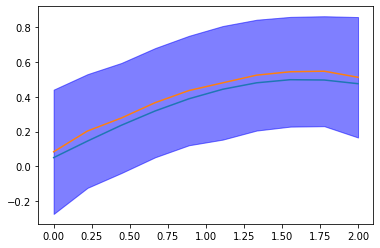

In [23]:
x_test = np.linspace(0, 2, 10).reshape(-1, 1)
y_test = demo_blr(x_test)
x_test = torch.from_numpy(x_test).float()
mu, std = bnn.predict(x_test, num_predictions = 200)

plt.figure(1)
plt.plot(x_test, y_test)
plt.plot(x_test, mu)
for c in range(4):
  plt.fill_between(x_test.squeeze(), (mu - 3 *std).squeeze(), (mu + 3 * std).squeeze(), alpha = c * 0.1, color = 'blue')

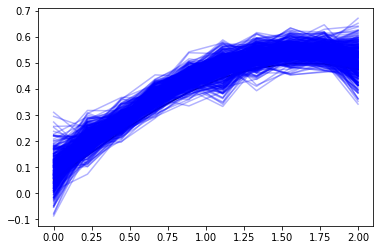

In [24]:
sampled_predictions = bnn.predict(x_test, num_predictions=400, aggregate=False)
plt.plot(x_test, y_test, color="black")
for yhat in sampled_predictions:
    plt.plot(x_test, yhat, color="blue", alpha=0.3)